In [ ]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from collections import defaultdict
import os
import PIL
from scipy.io import wavfile
import torchaudio
from IPython.display import Audio, display

In [ ]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!mkdir .kaggle
!mv kaggle.json .kaggle/
!mv .kaggle ~/

# Proyecto 1: Clasificación de Imagenes

De la página de [kaggle](https://www.kaggle.com/) he descargado el data set de clasificación de imágenes:

[dogs and cats dataset](https://www.kaggle.com/chetankv/dogs-cats-images)

## Reporte

A continuación se descarga el dataset de las imágenes:

In [ ]:
# TODO: Modificar esto acorde al dataset que se va a usar
!kaggle datasets download chetankv/dogs-cats-images
!unzip dogs-cats-images.zip

Para descargar el dataset lo que se hace es copiar el enlace después del primer "/" (chetankv/dogs-cats-images) y pegarlo en la primera línea de arriba después de download.

Dado que es un conjunto de imágenes y se descarga en un comprimido, se descomprime la carpeta con la segunda línea del código de arriba especificando el nombre de la carpeta, el cual se encuentra después del segundo "/" (dogs-cats-images) del enlace. Se copia y pega adicionando la extensión .zip al final.

Este tipo de dataset contiene 10000 imágenes en total de gatos y perros, las cuales están separadas en dos carpetas: test_set (2000 imágenes) y training_set (8000 imágenes).

Se utiliza la carpeta training_set para entrenar a la red neuronal diseñada y clasifique las imágenes. Posteriormente se pondrá a prueba al modelo con las imágenes de la carpeta test_set.

In [ ]:
# Esto no se necesita modificar. Son las funciones para entrenar el modelo.
# OPTIONAL:
# Si se desea se puede modificar para por ejemplo almacenar el accuracy y el loss de cada epoca para poder plotearlo luego
def evaluate(model, loader, crit):
  model.eval()
  total = 0
  corrects = 0
  avg_loss = 0
  for x, y in loader:
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    loss = crit(o,y)
    avg_loss += loss.item()
    corrects += torch.sum(torch.argmax(o,axis=1) == y).item()
    total += len(y)
  acc = 100* corrects / total
  avg_loss /= len(loader)  
  return avg_loss, acc

def train_one_epoch(model, train_loader, crit, optim):
  model.train()
  total = 0
  corrects = 0
  avg_loss = 0
  for x, y in train_loader: 
    optim.zero_grad()
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    loss = crit(o,y)
    avg_loss += loss.item()
    loss.backward()
    optim.step()
    corrects += torch.sum(torch.argmax(o,axis=1) == y).item()
    total += len(y)
  acc = 100 * corrects / total
  avg_loss /= len(train_loader)
  return avg_loss, acc

def train(model, train_loader, test_loader, crit, optim, epochs = 20):
  for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader,crit, optim)
    test_loss, test_acc = evaluate(model, test_loader, crit)
    print(f"epoch: {epoch}, train loss: {train_loss}, train acc: {train_acc}%, test loss: {test_loss}, test acc: {test_acc}%")

Estoy ingresando el comando **torchvision.transforms.RandomRotation(20)** y el comando **torchvision.transforms.RandomHorizontalFlip()**. El primero hace girar la imagen en un ángulo de 20 grados con cierta probabilidad, mientras que el segundo gira horizontalmente la imagen dada con cierta probabilidad (p=0.5).

In [ ]:
# Esto tampoco se necesita modificar.
# OPTIONAL:
# Se puede aumentar más transformaciones (data augmentation) o cambiar el tamaño del resizing.
img_transform = torchvision.transforms.Compose([
  torchvision.transforms.RandomRotation(20),
  torchvision.transforms.RandomHorizontalFlip(),
  torchvision.transforms.Resize((224,224)),
  torchvision.transforms.ToTensor()
])

Se coloca el path de las carpetas que se utilizarán para el entrenamiento y para la prueba.

In [ ]:
# TODO: Modificar el path en donde se encuentrar sus imagenes de training y testing
train_ds = torchvision.datasets.ImageFolder("./dataset/training_set",transform=img_transform)
test_ds = torchvision.datasets.ImageFolder("./dataset/test_set",transform=img_transform)

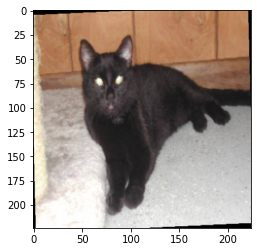

In [ ]:
# Esto es solo para poder ver un ejemplo de las imagenes que se estan usando
plt.imshow(train_ds[10][0].numpy().transpose(1,2,0))

Primero se hace un entrenamiento del modelo con shuffle = True y luego con shuffle = False.

In [ ]:
# Esto no se necesita modificar al menos que se quiera utilizar un batch size diferente
# OPTIONAL:
# Cambiar la opción de shuffle a False y observar que pasa con los input y targets que nos brinda el dataloader, que diferencias hay?
# Observar que pasa con el accuracy cuando no se realiza el shuffling y explicar porque.

train_dl = torch.utils.data.DataLoader(train_ds,batch_size=200,shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=200,shuffle=True)

**Se define el modelo**

En el informe se explica los layers que estoy utilizando.

In [ ]:
# TODO: Definir el modelo
model = nn.Sequential(
  # DEFINIR LOS LAYERS
  nn.Conv2d(3,16,7,bias=False),
  nn.BatchNorm2d(16),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),

  nn.Conv2d(16,32,3,bias=False),
  nn.BatchNorm2d(32),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  
  nn.Conv2d(32,32,3,bias=False),
  nn.BatchNorm2d(32),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  
  nn.Conv2d(32,64,3,bias=False),
  nn.BatchNorm2d(64),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  
  nn.Conv2d(64,64,3,bias=False),
  nn.BatchNorm2d(64),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  
  nn.Conv2d(64,128,3,bias=False),
  nn.BatchNorm2d(128),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),

  nn.Flatten(),
  nn.Linear(128,2)
).to(dev)

In [ ]:
# Esto tampoco se necesita modificar
# OPTIONAL:
# Se puede aumentar o disminuir el learning rate para observar como es la evolucion de los accuracy y loss.

crit = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(),lr=0.01)
train(model,train_dl, test_dl, crit, optim, epochs=10)

epoch: 0, train loss: 0.6480967372655868, train acc: 62.3625%, test loss: 0.7209438204765319, test acc: 51.95%
epoch: 1, train loss: 0.5938687548041344, train acc: 69.0875%, test loss: 0.6050942301750183, test acc: 68.85%
epoch: 2, train loss: 0.5571971215307713, train acc: 71.3625%, test loss: 0.6768231570720673, test acc: 64.3%
epoch: 3, train loss: 0.5313688389956951, train acc: 72.8375%, test loss: 0.5521488904953002, test acc: 71.2%
epoch: 4, train loss: 0.5105228863656521, train acc: 75.2875%, test loss: 0.5245402067899704, test acc: 74.3%
epoch: 5, train loss: 0.4962794929742813, train acc: 76.1875%, test loss: 0.5064697086811065, test acc: 76.2%
epoch: 6, train loss: 0.4796856127679348, train acc: 77.0375%, test loss: 0.4952727884054184, test acc: 76.65%
epoch: 7, train loss: 0.4702434577047825, train acc: 77.575%, test loss: 0.49737532436847687, test acc: 77.15%
epoch: 8, train loss: 0.4572615310549736, train acc: 78.825%, test loss: 0.5434951096773147, test acc: 71.95%
epoch:

**Poniendo a prueba el modelo**

Por defecto la variable *pred* toma los valores 0 (para gatos) o 1 (para perros), se hizo una pequeña modificación con la finalidad de que imprima qué tipo de animal es.

Es un gato


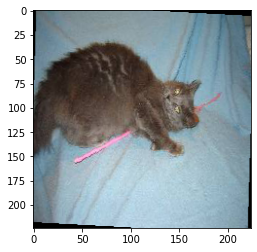

In [ ]:
model.eval()
idx = 15
x, y = test_ds[idx]
x_numpy = x.numpy().transpose(1,2,0)
N, H, W = x.shape
x = x.reshape(1,N,H,W)
pred = torch.argmax(model(x.to(dev)).cpu()).item()
if pred==1:
  print('Es un perro')
if pred==0:
  print('Es un gato')
plt.imshow(x_numpy)